# 回帰分析
- ### 連続値をとる目的変数の予測

## Housingデータセットの検索

### Housingデータセット：506サンプルの特徴量
- CRIM: 犯罪発生率（人口単位）
- ZN: 25,000平方フィート以上の住宅区画の割合
- INDUS: 非小売業の土地面積の割合（人口単位）
- CHAS: チャールズ川沿いかどうか
- NOX: 窒素酸化物の濃度（pphm単位）
- RM: 1戸当たりの平均部屋数
- AGE: 1940年よりも前に建てられた家屋の割合
- DIS: ボストンの主な5つの雇用圏までの重み付きの距離
- RAD: 幹線道路へのアクセス指数
- TAX: 10,000ドルあたりの所得税率
- PTRATIO: 教師あたりの生徒の数（人口単位）
- B: $1000(Bk - 0.63)^2$として計算（$Bk$はアフリカ系アメリカ人居住者の割合）
- LSTAT: 低所得者の割合
- MEDV: 住宅価格の中央値（単位1,000ドル）

In [4]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### データセットの重要な特性を可視化

探索的データ解析（Exploratory Data Analysis :EDA）

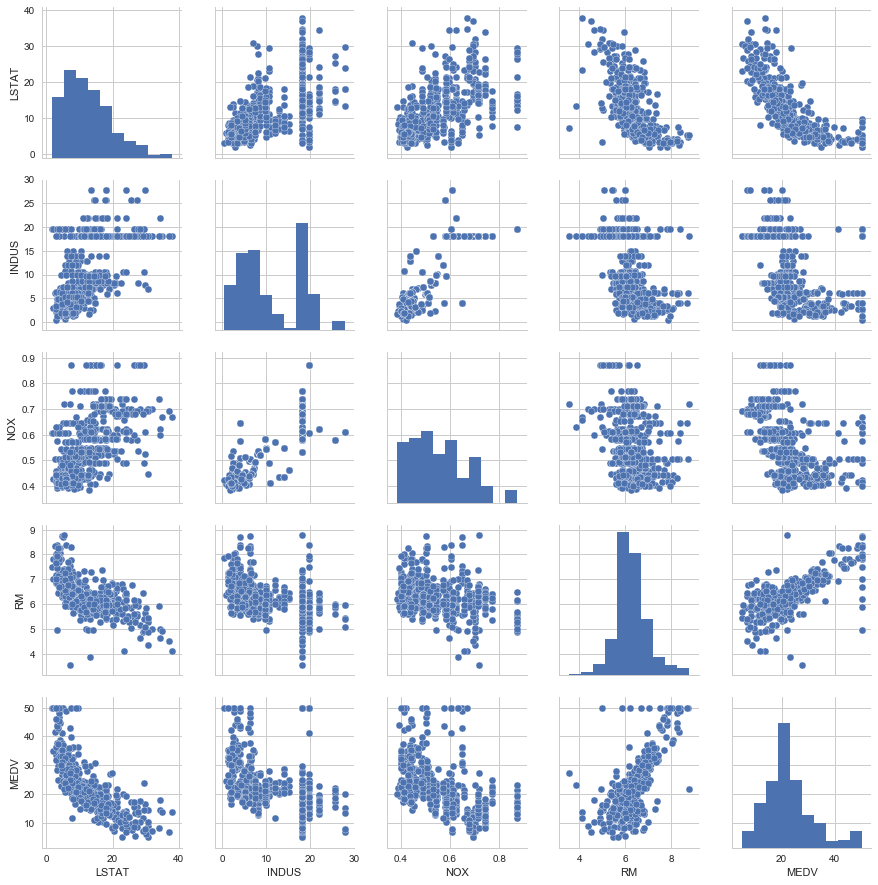

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# グラフスタイルの指定（whitegrid: 白背景，　notebook: デフォルトサイズ）
sns.set(style = 'whitegrid', context = 'notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size = 2.5)
plt.show()

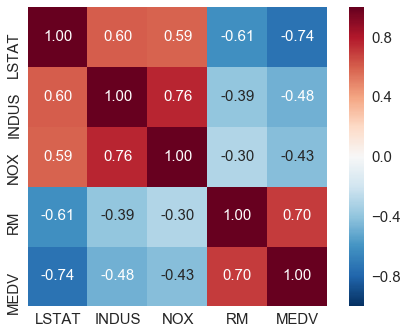

In [7]:
import numpy as np

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', 
                 annot_kws = {'size': 15}, yticklabels = cols, xticklabels = cols)
plt.show()

## 最小二乗線形回帰モデルの実装

In [8]:
import lrgd
from sklearn.preprocessing import StandardScaler

X = df[['RM']].values
y = df['MEDV'].values

sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = lrgd.LinearRegressionGD()
lr.fit(X_std, y_std)

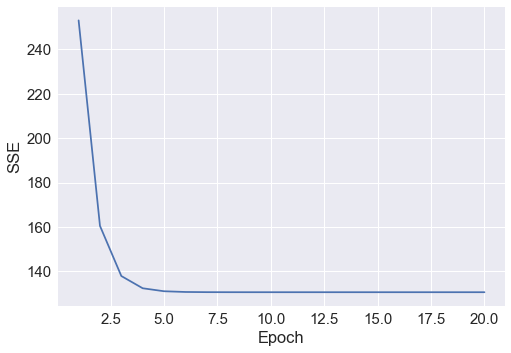

In [9]:
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

ヘルパー関数の定義

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def lin_regplot(X, y, model):
    plt.scatter(X, y, c = 'blue')
    plt.plot(X, model.predict(X), color = 'red')
    return None

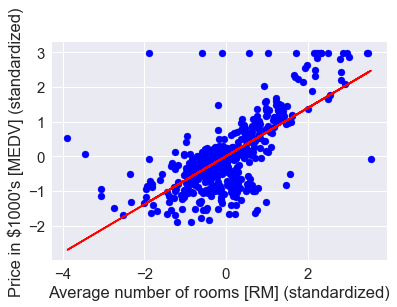

In [11]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

直観的ではあるが，部屋数だけでは在宅価格をうまく説明しきれないケースも多い

In [12]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


### scikit-learnを使って回帰モデルの係数を推定

In [13]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


標準化されていないRM変数とMEDV変数を学習

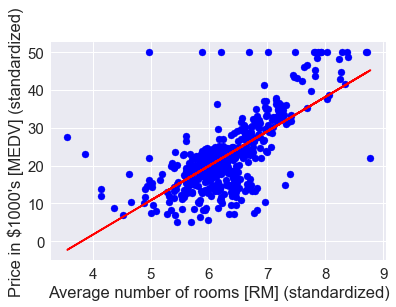

In [14]:
lin_regplot(X, y,slr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

## RANSACを使ったロバストモデルの学習

In [15]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

ransac = RANSACRegressor(LinearRegression(),
                         max_trials = 100,
                         min_samples = 50,
                         loss = 'absolute_loss', #各サンプルに対して列方向に各成分の絶対和を算出
                         residual_threshold = 5.0,
                         random_state = 0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

学習済みの線形回帰モデルから正常値と外れ値を取得

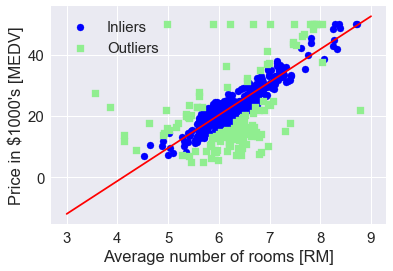

In [16]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask], c = 'blue', marker = 'o', label = 'Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c = 'lightgreen', marker = 's', label = 'Outliers')

plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [17]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


## 線形回帰モデルの性能評価

In [18]:
from sklearn.model_selection import train_test_split

# df.iloc[:, :-1] : 最後の列を除去する
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

### 残差プロット

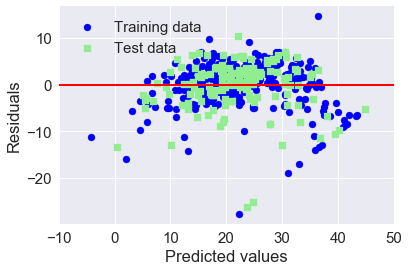

In [19]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

外れ値は中央の直線から大きく離れている点

### 平均二乗誤差

In [20]:
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                        mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


過学習が発生している
- トレーニングデータセットのMSE　＜　テストデータセットのMSE

### $R^2$スコア

In [21]:
from sklearn.metrics import r2_score

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                        r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


## 回帰に正則化手法を使用

リッジ回帰を初期化するコード

In [22]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 1.0)

LASSO回帰器を初期化するコード

In [23]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1.0)

ElasticNet

In [24]:
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet(alpha = 1.0, l1_ratio = 0.5)

## 多項式回帰
- 線形回帰モデルから曲線を見出す

$y = w_0 + w_1 x + w_2 x^2 + \cdots + w_d x^d$

1．多項式の2次の項を追加する

In [25]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])

lr = LinearRegression()
pr = LinearRegression()

quadratic = PolynomialFeatures(degree = 2)
X_quad = quadratic.fit_transform(X)

2．単純な線形回帰モデルを学習させる

In [26]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

3．多項式回帰のために変換された特徴量で複数の回帰モデルを学習させる

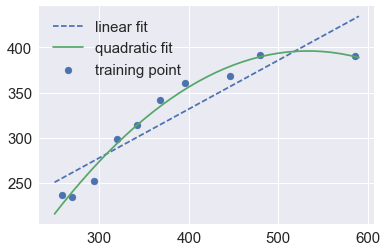

In [27]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X, y, label = 'training point')
plt.plot(X_fit, y_lin_fit, label = 'linear fit', linestyle = '--')
plt.plot(X_fit, y_quad_fit, label = 'quadratic fit')
plt.legend(loc = 'upper left')
plt.show()

In [28]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


### Housingデータセットで非線形関係をモデリング

In [29]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

多項式の特徴量を作成

In [30]:
quadratic = PolynomialFeatures(degree = 2)
cubic = PolynomialFeatures(degree = 3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

線形回帰モデルの学習

In [31]:
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

2次の多項式回帰モデルの学習

In [32]:
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

3次の多項式回帰モデル

In [33]:
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

各モデルの結果をプロット

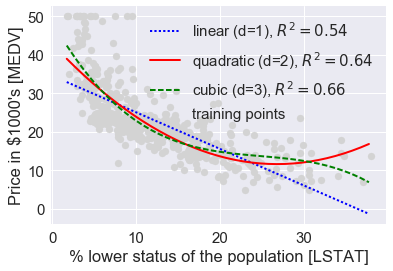

In [34]:
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.show()

LSTAT変数の対数とMEDV変数の平方根により  
線形回帰モデルの学習に適した線形特徴空間にデータを射影

In [36]:
X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min() - 1, X_log.max() + 1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

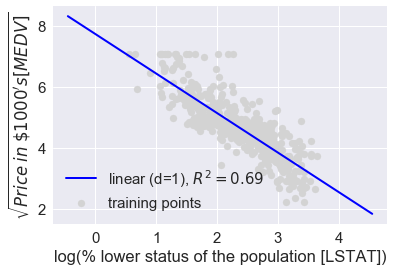

In [37]:
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.show()

### ランダムフォレストを使って非線形関係に対処

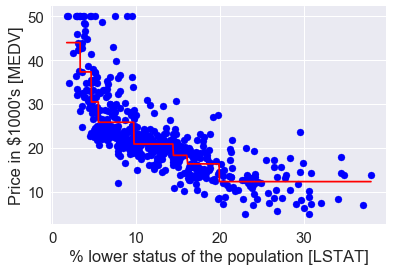

In [42]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth = 3)
tree.fit(X, y)
# flatten(): 1段ネストしたリストを1次元配列に
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

### ランダムフォレスト回帰

In [43]:
from sklearn.ensemble import RandomForestRegressor

X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

forest = RandomForestRegressor(n_estimators = 1000,
                               criterion = 'mse',
                               random_state = 1,
                               n_jobs = -1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


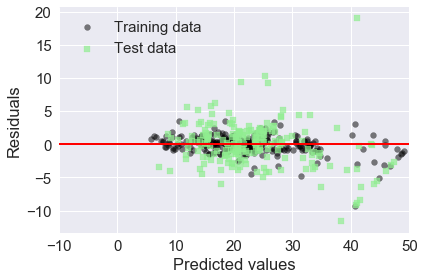

In [44]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()